In [2]:
import os

import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import gval

from mosaic_inundation import Mosaic_inundation
from inundate_gms import Inundate_gms

In [3]:
hucs = ['12020001']

base_dir = '/foss_fim'
outputs_dir = os.path.join(base_dir,'outputs')
hydrofabric_dir = os.path.join(outputs_dir, 'fim_4_3_3_4') 

predicted_raster_path = os.path.join(outputs_dir,'inundation.tif')

In [4]:
benchmark_flows = os.path.join(outputs_dir, 'ble_huc_12020001_flows_500yr.csv')
pd.read_csv(benchmark_flows)

,feature_id,discharge
0,1077621,1471.350711
1,1077623,1471.326076
2,1077625,1471.359773
3,1077643,1471.259531
4,4450864,18.868081
...,...,...
1177,4454480,60.251170
1178,4456676,97.672166
1179,4456680,202.475506
1180,4456682,748.358754


<Axes: >

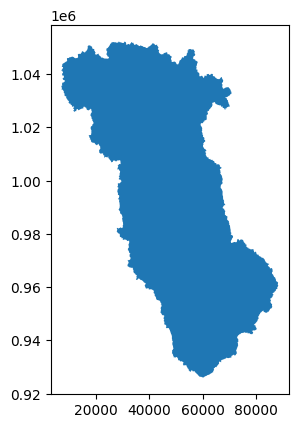

In [5]:
mask = os.path.join(hydrofabric_dir, hucs[0], 'wbd.gpkg')
gpd.read_file(mask).plot()

In [6]:
map_file = Inundate_gms(hydrofabric_dir=hydrofabric_dir,
                        forecast=benchmark_flows,
                        hucs=hucs,
                        inundation_raster=predicted_raster_path)
map_file

,huc8,branchID,inundation_rasters,depths_rasters,inundation_polygons
0,12020001,0,/foss_fim/outputs/inundation_12020001_0.tif,None,None
1,12020001,1077000002,/foss_fim/outputs/inundation_12020001_10770000...,None,None
2,12020001,1077000003,/foss_fim/outputs/inundation_12020001_10770000...,None,None
3,12020001,1077000004,/foss_fim/outputs/inundation_12020001_10770000...,None,None
4,12020001,1077000005,/foss_fim/outputs/inundation_12020001_10770000...,None,None
5,12020001,1077000006,/foss_fim/outputs/inundation_12020001_10770000...,None,None
6,12020001,1077000007,/foss_fim/outputs/inundation_12020001_10770000...,None,None
7,12020001,1077000001,/foss_fim/outputs/inundation_12020001_10770000...,None,None
8,12020001,1077000008,/foss_fim/outputs/inundation_12020001_10770000...,None,None
9,12020001,1077000009,/foss_fim/outputs/inundation_12020001_10770000...,None,None


In [7]:
Mosaic_inundation(map_file,
                  mosaic_attribute='inundation_rasters',
                  mosaic_output=predicted_raster_path,
                  mask=mask,
                  unit_attribute_name='huc8')

Mosaicing FIMs:   0%|          | 0/1 [00:00<?, ?it/s]

... Masking ...


Mosaicing FIMs: 100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


'/foss_fim/outputs/inundation.tif'

In [8]:
candidate = rxr.open_rasterio(predicted_raster_path, mask_and_scale=True)
benchmark = rxr.open_rasterio(os.path.join(outputs_dir,'ble_huc_12020001_extent_500yr.tif'), mask_and_scale=True)

In [9]:
candidate.data = xr.where(candidate < 0, 0, candidate)
candidate.data = xr.where(candidate > 0, 1, candidate)

In [ ]:
candidate.plot()

In [9]:
agreement_map, cross_tab, metric_df = candidate.gval.categorical_compare(benchmark,
                                                                      positive_categories=[1],
                                                                      negative_categories=[0])

In [1]:
del candidate, benchmark
import gc
gc.collect()

NameError: name 'candidate' is not defined

In [ ]:
agreement_map.plot()

In [ ]:
cross_tab

In [ ]:
metric_df